In [1]:
import numpy as np
import matplotlib.pyplot as plt
import beaconsHelper
import trilateration
import CoreLocation

In [2]:
label = "cattalyya-13-vertical"
data = beaconsHelper.load_rssi_data(label)

In [3]:
data_by_id = {}
rssi_data_by_timestamp = beaconsHelper.get_rssi_data_by_timestamp(data, rssi_thres=-66)
print(len(rssi_data_by_timestamp.keys()))

867


### Average prediction over 1 minute

In [4]:
for beacon_id in range(1, 10):
    ibeacon = beaconsHelper.get_rssi_data_from_id(beacon_id, rssi_data_by_timestamp)
#     print ibeacon
    ibeacon = beaconsHelper.get_smooth_rssi_data(ibeacon, 10, option="median")
#     print "\n\n\n",ibeacon
    data_by_id[beacon_id] = ibeacon
data_by_timestamp = beaconsHelper.convert_rssi_data_by_id_to_timestamp(data_by_id)
data_by_timestamp = beaconsHelper.convert_to_rough_timestamp(data_by_timestamp)
# print(list(sorted(data_by_timestamp.keys())))

Locs_cattalyya: [1526270438.0: (92.35646798595215, 28.686618564935614), 1526270443.0: (104.62749162719192, 139.14911542510848), 1526270444.0: (107.43744084031512, 201.55403043815252), 1526270445.0: (116.60609048955087, 118.88498182092039), 1526270449.0: (138.56877518502858, 34.40772160436077), 1526270450.0: (215.3587356486428, 152.3387802409416), 1526270452.0: (115.31566804206234, 150.29984826298207), 1526270453.0: (145.35115235544473, 122.82339297366306), 1526270456.0: (161.10485572220165, 241.8279469337693), 1526270457.0: (161.34102299529795, 202.6501196134378), 1526270464.0: (135.64121541794054, 184.4257486756051), 1526270465.0: (70.52034724960347, 289.85530575266245), 1526270467.0: (64.26303905801487, 295.49358813528005), 1526270470.0: (22.170979262514194, 108.6861267501453), 1526270472.0: (95.95109442109893, 39.763981075189946), 1526270474.0: (115.70874880586732, 138.51045132706827), 1526270475.0: (29.87179791506273, 160.53676676555884), 1526270477.0: (85.93381579481056, 77.510973

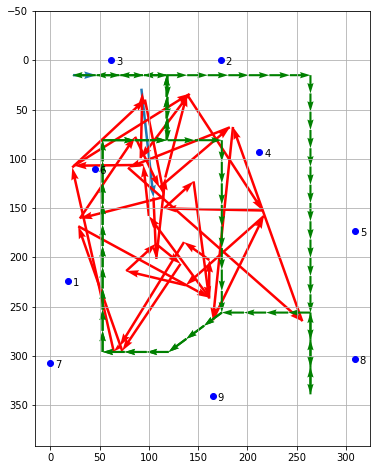

In [5]:
conversion = 39.97 # meters to inches
A = -64
n = 2

subject_name = "cattalyya"
room = CoreLocation.Room.import_room_data('room_measurement.json', "G5-may13")
beacon_locations = room.beacons.get_dict_by_label()
predicted_locations = CoreLocation.Locations(subject=subject_name)
xs, ys = zip(*beacon_locations.values())
margin = 50
axis_limits = [min(xs) - margin, max(xs) + margin, min(ys) - margin, max(ys) + margin]
# print data_by_timestamp
sorted_timestamps = list(sorted(data_by_timestamp.keys()))
# print(sorted_timestamps)
for timestamp in sorted_timestamps:
# for timestamp in data_by_timestam.
    rssi_values = beaconsHelper.get_rssi_values(data_by_timestamp, timestamp)
    beacon_distances = beaconsHelper.get_beacon_distances_from_rssi(rssi_values, A, n, conversion)
#     predicted_loc = trilateration.trilaterate_ratios(beacon_locations, beacon_distances)
    predicted_loc = trilateration.trilaterate(beacon_locations, beacon_distances, L2=True)

    # TODO: check why None result from trilateration
    if predicted_loc is not None:
        predicted_locations.add_np_point(predicted_loc, timestamp)
print(predicted_locations)
room.visualize_with_groundtruth(predicted_locations)

In [ ]:
# # NO Smooth
# data_by_timestamp = ibeaconsHelper.get_rssi_data_by_timestamp(data) # old data format use get_data_by_timestamp

# timestamp = 1525668397.2775578 # ray
# # timestamp = 1525666731.260067 # cattalyya
# conversion = 39.97 # meters to inches
# A = -64
# n = 2

# subject_name = "cattalyya"
# predicted_locations = CoreLocation.Locations(subject=subject_name)
# xs, ys = zip(*beacon_locations.values())
# margin = 50
# axis_limits = [min(xs) - margin, max(xs) + margin, min(ys) - margin, max(ys) + margin]
# # print data_by_timestamp

# for timestamp in data_by_timestamp.keys():
#     rssi_values = ibeaconsHelper.get_rssi_values(data_by_timestamp, timestamp)
#     beacon_distances = ibeaconsHelper.get_beacon_distances_from_rssi(rssi_values, A, n, conversion)
#     predicted_loc = trilateration.trilaterate(beacon_locations, beacon_distances, L2=True)
#     # TODO: check why None result from trilateration
#     if predicted_loc is not None:
#         predicted_locations.add_np_point(predicted_loc, timestamp)
    
# subject_point = CoreLocation.Point2D.numpy_to_point(client_locations[subject_name], None)
# predicted_locations.visualize(subject_point, ax_limits=axis_limits)
# predicted_locations.plot(subject_point, ax_limits=axis_limits)

# # Hyperbolic multilateration 


Should we filter out data if rssi are too low? It's no longer reliable after it's below some threshold.

# Results

In [ ]:
def plot_prediction(beacon_locations, beacon_distances, predicted_location, client_names):
    margin = 50
    xs, ys = zip(*beacon_locations.values())
    axis_limits = [min(xs) - margin, max(xs) + margin, min(ys) - margin, max(ys) + margin]
    fig, ax = plt.subplots()
    
    # assume all beacons in beacon_distances are also in beacon_locations
    for minor in beacon_distances:
        x, y = beacon_locations[minor][:2]
        distance = beacon_distances[minor]
        circle = plt.Circle((x, y), distance, fill=False)
        ax.add_artist(circle)
        ax.plot(x, y, 'bo')
        ax.annotate(minor, (x, y), xytext=(x + 5, y + 5))

    for client_name in client_names:
        x, y = client_locations[client_name]
        ax.plot(x, y, 'go')
        ax.annotate(client_name, (x, y), xytext=(x + 5, y + 5))

    # prediction
    predicted_x, predicted_y = predicted_location[:2]
    ax.plot(predicted_x, predicted_y, 'ro')
    ax.annotate("prediction", (predicted_x, predicted_y), xytext=(predicted_x + 5, predicted_y + 5))
    plt.axis(axis_limits)
    ax.axis('equal')
    plt.title("A: %.2f, n: %.2f" % (A, n))
    plt.show()

In [ ]:
plot_prediction(beacon_locations, beacon_distances, predicted_locations.points[10].coord, ["ray"])

In [ ]:
print rssi_values